# E13. 어제 오른 내 주식, 과연 내일은?

## 프로젝트 목표 : ARIMA모델을 이해하고 훈련시켜 주식을 예측해 보자

## STEP 1 : 시계열 데이터 준비

    칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
    날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
2020-03-02    55000.0
Name: Close, dtype: float64

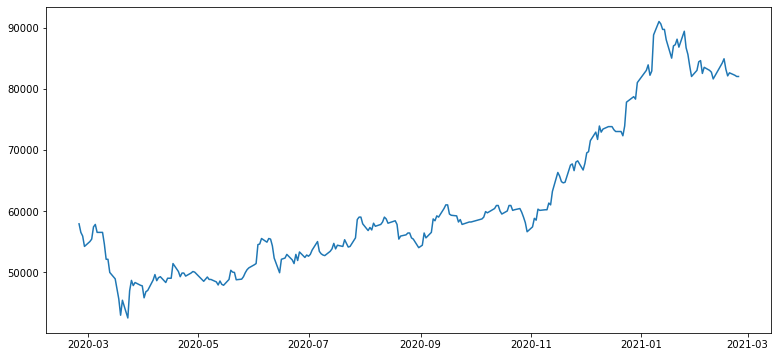

In [16]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기

plt.plot(ts)

## STEP 2 : 각종 전처리 수행

### 결측치 처리 및 로그변환

In [17]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [18]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

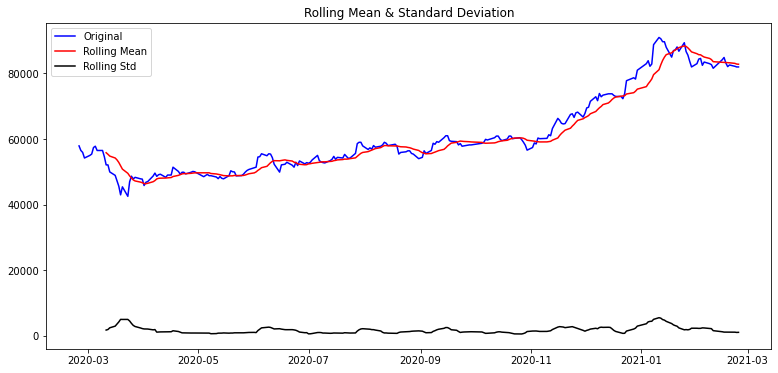

In [19]:
plot_rolling_statistics(ts, window=12)

In [20]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [22]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.089972
p-value                          0.965370
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


#### P-value 가 0.96 으로 1에 가깝게 나타 났으므로 귀무가설 (시계열 데이터가 안정적이지 않다)에 가까운 결론이 나왔음

#### 상단의 종가 기준의 그래프를 보더라도 패턴이 보이거나 Stationary 적으로 보이지 않음

#### 결측치는 보이지 않습니다. 다행입니다

In [23]:
# 로그 변환
ts_log = np.log(ts)

#### Augmented Dickey-Fuller Test를 수행

In [24]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.094300
p-value                          0.950003
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


#### P-value가 줄어 들지 않았다. Log 변환 한다고 일정한 패턴이 보이는 시계열 데이터는 아닌 것으로 보인다.

### Moving average 제거 - 추세(Trend) 상쇄하기

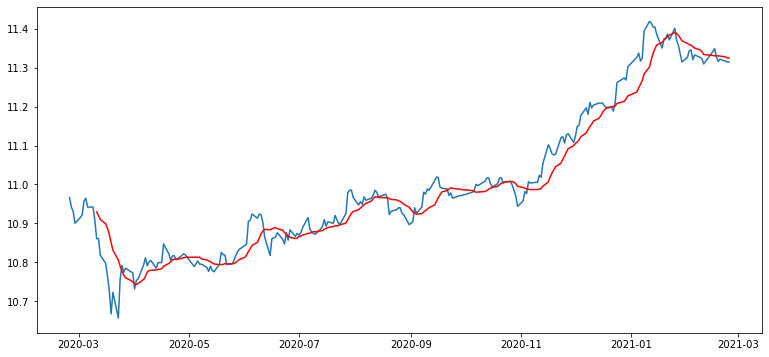

In [25]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [26]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-02-25         NaN
2020-02-26         NaN
2020-02-27         NaN
2020-02-28         NaN
2020-03-02         NaN
2020-03-03         NaN
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11   -0.068487
2020-03-12   -0.059691
2020-03-13   -0.091566
2020-03-16   -0.101662
Name: Close, dtype: float64

In [27]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-03-11   -0.068487
2020-03-12   -0.059691
2020-03-13   -0.091566
2020-03-16   -0.101662
2020-03-17   -0.123581
2020-03-18   -0.144565
2020-03-19   -0.183224
2020-03-20   -0.108205
2020-03-23   -0.148589
2020-03-24   -0.033580
2020-03-25    0.014454
2020-03-26    0.007912
2020-03-27    0.024629
2020-03-30    0.022360
2020-03-31    0.024022
Name: Close, dtype: float64

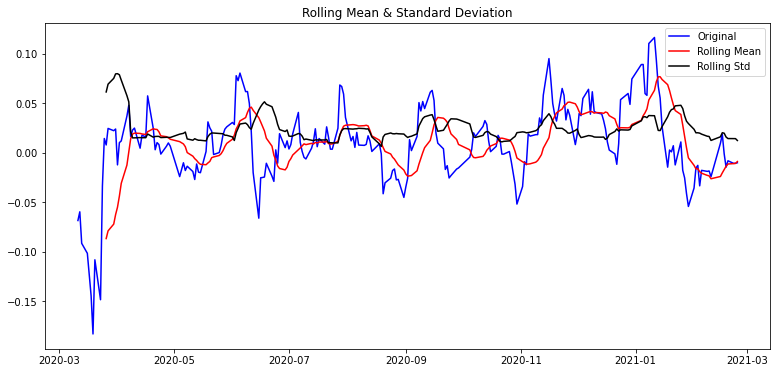

In [28]:
plot_rolling_statistics(ts_log_moving_avg)

#### 약간 패턴이 보이기 시작한다...

In [29]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.196577
p-value                          0.000668
#Lags Used                       0.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


### !!! P-value 가 0에 가깝게 줄어 들었다.

### 차분(Differencing) - 계절성(Seasonality) 상쇄하기

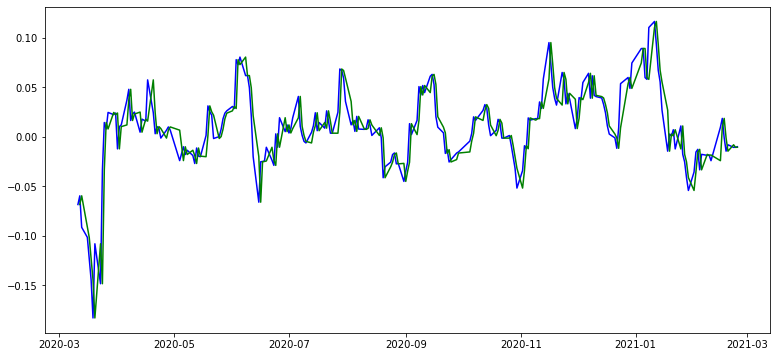

In [30]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

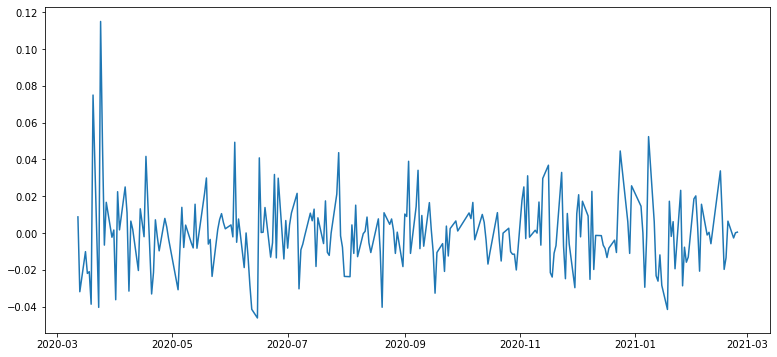

In [31]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

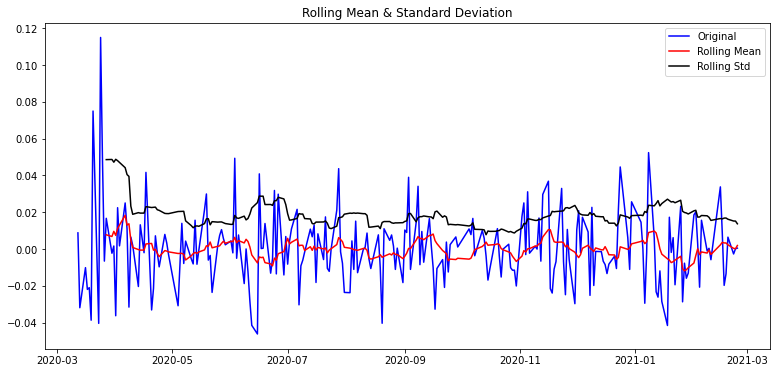

In [32]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [33]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.590965e+01
p-value                        8.151389e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


#### 오~~  차분과 계절성 형태도 상쇄하니 P-value 가 0에 가깝다

## STEP 3 : 시계열 안정성 분석

-정성적 그래프 분석
-정량적 Augmented Dicky-Fuller Test
-시계열 분해(Time Series Decomposition)
-Residual 안정성 확인

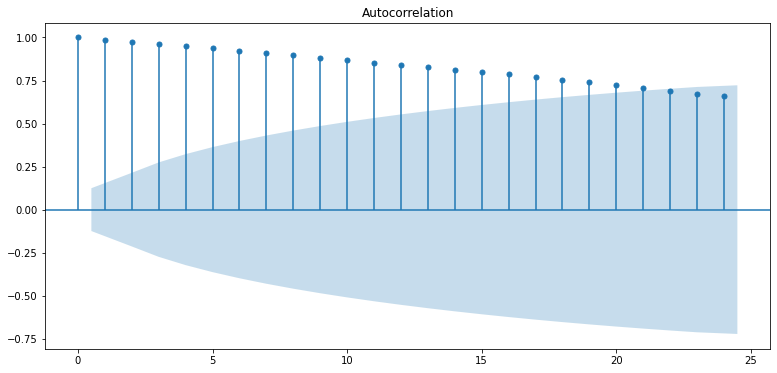

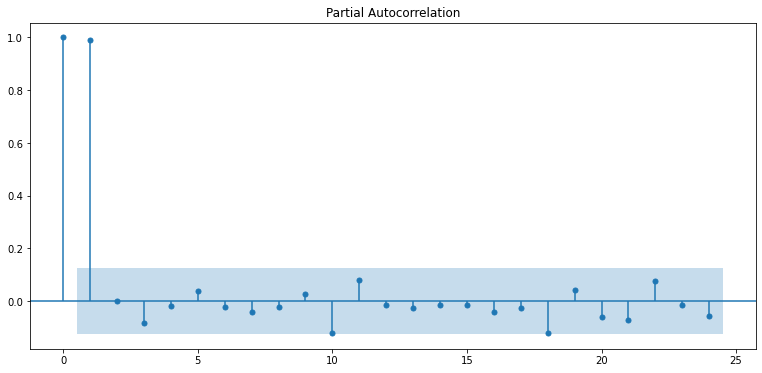

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.600368e+01
p-value                        6.469449e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


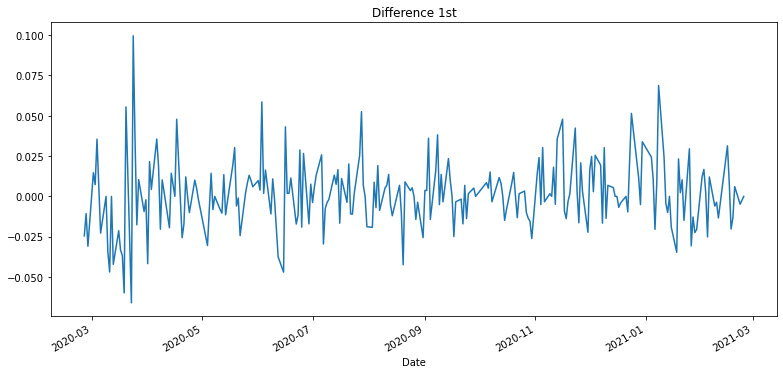

In [38]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.545669e+00
p-value                        3.288678e-11
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


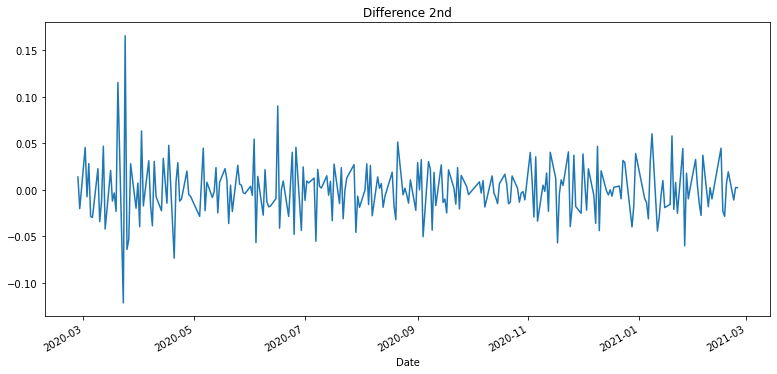

In [39]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 학습 데이터 분리

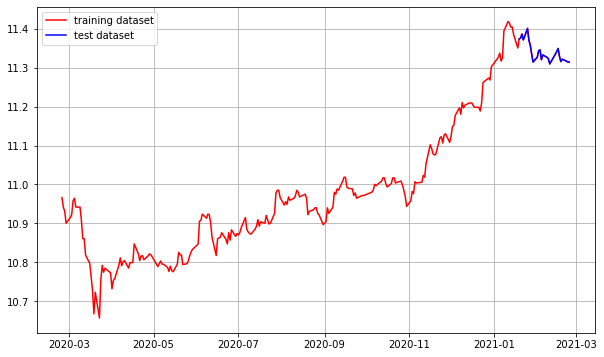

In [40]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [41]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-02-25    10.966473
2020-02-26    10.941996
Name: Close, dtype: float64
(223,)
(25,)


## ARIMA 모델 훈련

In [42]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 536.370
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 04 Mar 2021   AIC                          -1066.741
Time:                        20:19:03   BIC                          -1056.533
Sample:                             1   HQIC                         -1062.619
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0017      0.001      1.206      0.228      -0.001       0.005
ar.L1.D.Close    -0.0095      0.068     -0.141      0.888      -0.142       0.123
                                    Root

/home/aiffel-dj29/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj29/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

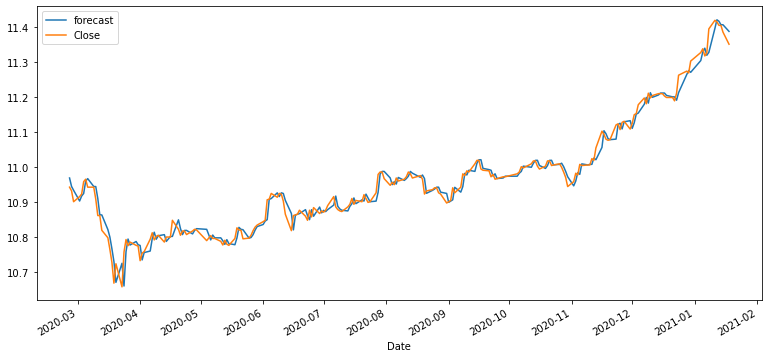

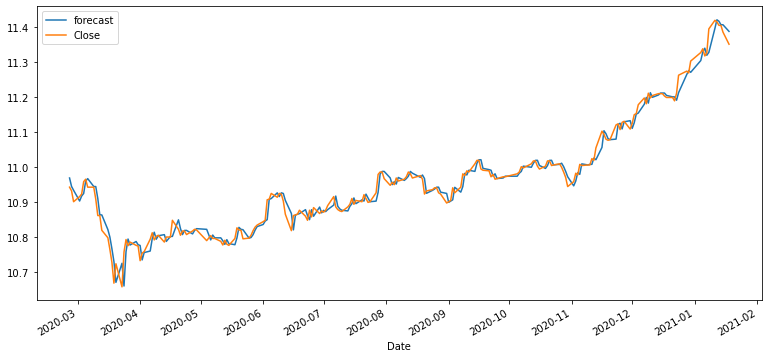

In [43]:
fitted_m.plot_predict()

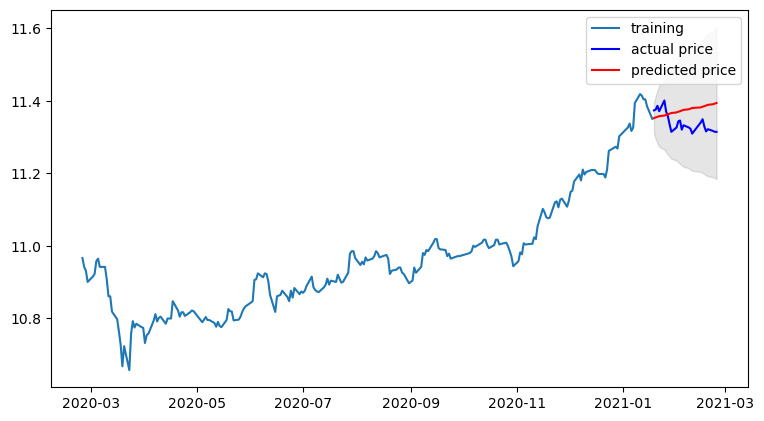

In [44]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### ?? Predicted Price가 이상하게... 상승만 한다..

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17204774.540261157
MAE:  3725.949259626905
RMSE:  4147.863852666956
MAPE: 4.47%


#### MAPE 기준으로 4.4% 오차가 발생하지만... 데이터가 적어서 그런가...  오차의 크기는 작지만 ...   대세 상승으로 보기에는 무리가 있어 보임

## 다른 주식 종목 예측해 보기

In [48]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/stock_prediction/data/001470.KS.csv'
df2 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts2 = df2['Close']

ts2.head()

Date
2017-07-04    1566.0
2017-07-05    1600.0
2017-07-06    1724.0
2017-07-07    1688.0
2017-07-10    1732.0
Name: Close, dtype: float64

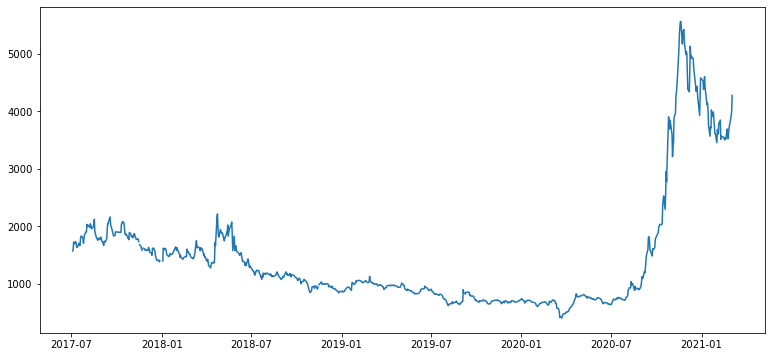

In [49]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기

plt.plot(ts2)

In [50]:
# 결측치 처리
ts2=ts2.interpolate(method='time')
ts2[ts2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

#### 결측치 없음

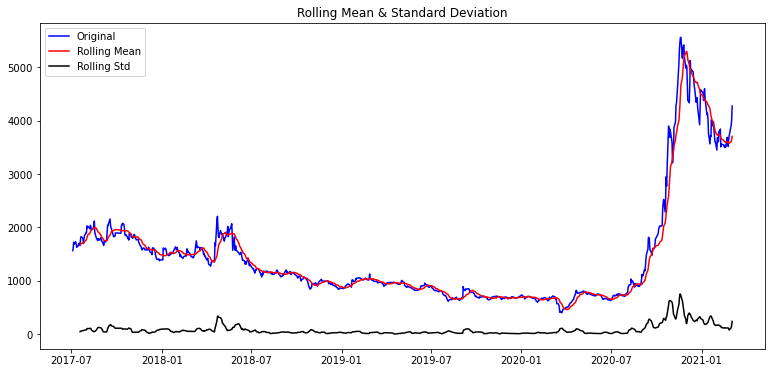

In [51]:
plot_rolling_statistics(ts2, window=12)

In [52]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                  -0.761757
p-value                          0.830099
#Lags Used                      20.000000
Number of Observations Used    876.000000
Critical Value (1%)             -3.437837
Critical Value (5%)             -2.864845
Critical Value (10%)            -2.568530
dtype: float64


### P-value 0.83 로 1에 가깝기 때문에 아직 stationary 데이터가 아니다.

In [53]:
# 로그 변환
ts2_log = np.log(ts2)

In [54]:
augmented_dickey_fuller_test(ts2_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.323019
p-value                          0.922180
#Lags Used                       3.000000
Number of Observations Used    893.000000
Critical Value (1%)             -3.437694
Critical Value (5%)             -2.864782
Critical Value (10%)            -2.568496
dtype: float64


### 0.83 --> 0.922 P-value 가 오히려 올라옴

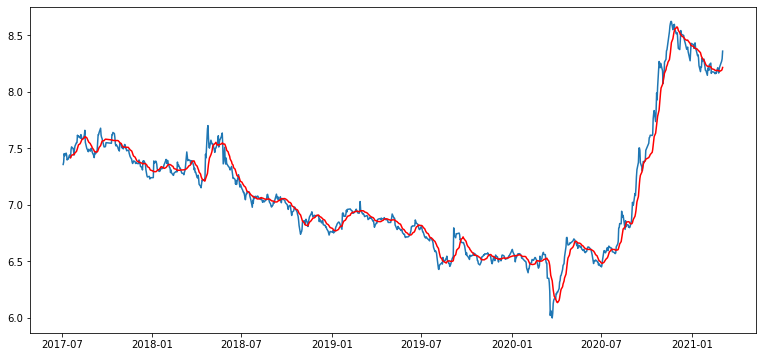

In [55]:
moving_avg2 = ts2_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts2_log)
plt.plot(moving_avg2, color='red')

In [56]:
ts_log_moving_avg2 = ts2_log - moving_avg2 # 변화량 제거
ts_log_moving_avg2.head(15)

Date
2017-07-04         NaN
2017-07-05         NaN
2017-07-06         NaN
2017-07-07         NaN
2017-07-10         NaN
2017-07-11         NaN
2017-07-12         NaN
2017-07-13         NaN
2017-07-14         NaN
2017-07-17         NaN
2017-07-18         NaN
2017-07-19    0.000825
2017-07-20    0.060624
2017-07-21    0.073769
2017-07-24    0.056695
Name: Close, dtype: float64

In [58]:
ts_log_moving_avg2.dropna(inplace=True)  ## 결측치 제거
ts_log_moving_avg2.head(15)

Date
2017-07-19    0.000825
2017-07-20    0.060624
2017-07-21    0.073769
2017-07-24    0.056695
2017-07-25    0.034677
2017-07-26   -0.005300
2017-07-27    0.044076
2017-07-28    0.060171
2017-07-31    0.077927
2017-08-01    0.065663
2017-08-02    0.117257
2017-08-03    0.084388
2017-08-04    0.081186
2017-08-07    0.058131
2017-08-08    0.043670
Name: Close, dtype: float64

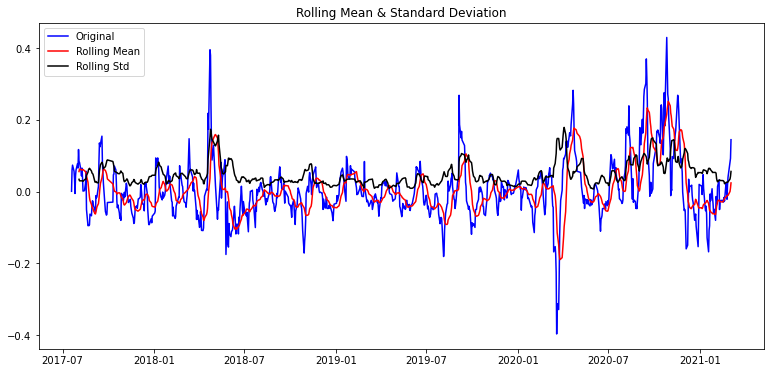

In [59]:
plot_rolling_statistics(ts_log_moving_avg2)

In [60]:
augmented_dickey_fuller_test(ts_log_moving_avg2)

Results of Dickey-Fuller Test:
Test Statistic                -5.673902e+00
p-value                        8.794121e-07
#Lags Used                     1.200000e+01
Number of Observations Used    8.730000e+02
Critical Value (1%)           -3.437863e+00
Critical Value (5%)           -2.864856e+00
Critical Value (10%)          -2.568536e+00
dtype: float64


### P-value 가 0에 가깝게 떨어 졌다.

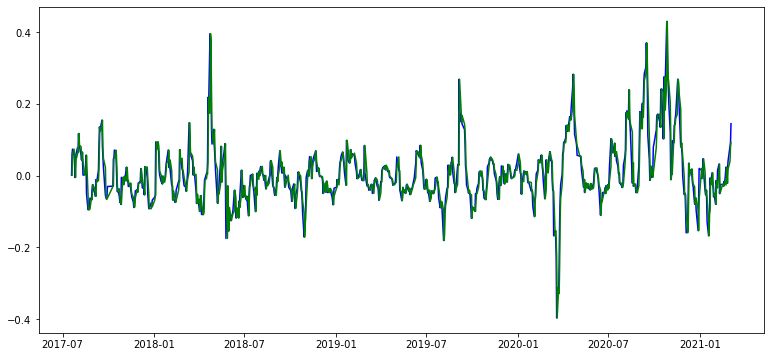

In [61]:
ts_log_moving_avg_shift2 = ts_log_moving_avg2.shift()

plt.plot(ts_log_moving_avg2, color='blue')
plt.plot(ts_log_moving_avg_shift2, color='green')

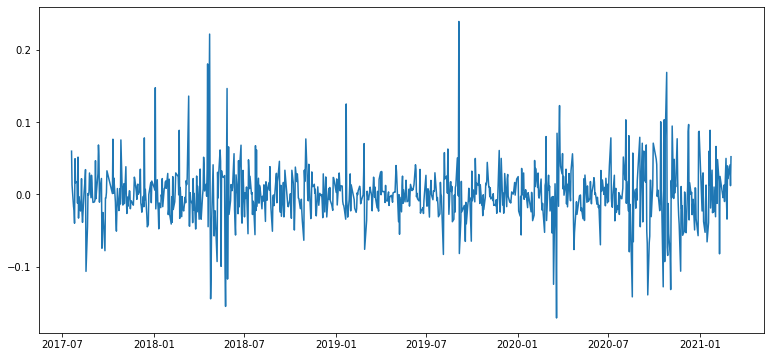

In [63]:
ts_log_moving_avg_diff2 = ts_log_moving_avg2 - ts_log_moving_avg_shift2
ts_log_moving_avg_diff2.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff2)

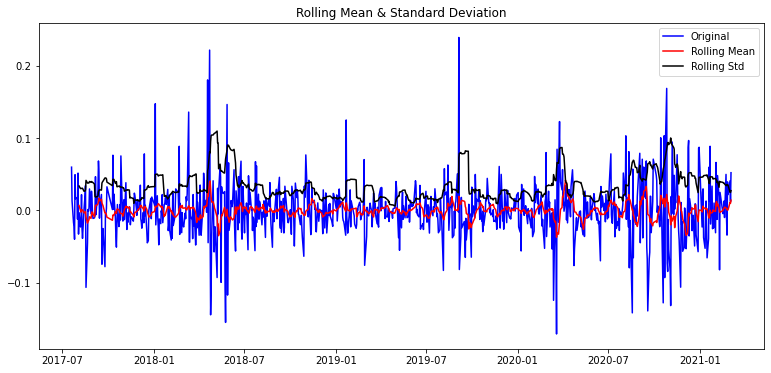

In [64]:
plot_rolling_statistics(ts_log_moving_avg_diff2)

In [65]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff2)

Results of Dickey-Fuller Test:
Test Statistic                -1.005708e+01
p-value                        1.364079e-17
#Lags Used                     2.000000e+01
Number of Observations Used    8.640000e+02
Critical Value (1%)           -3.437941e+00
Critical Value (5%)           -2.864891e+00
Critical Value (10%)          -2.568554e+00
dtype: float64


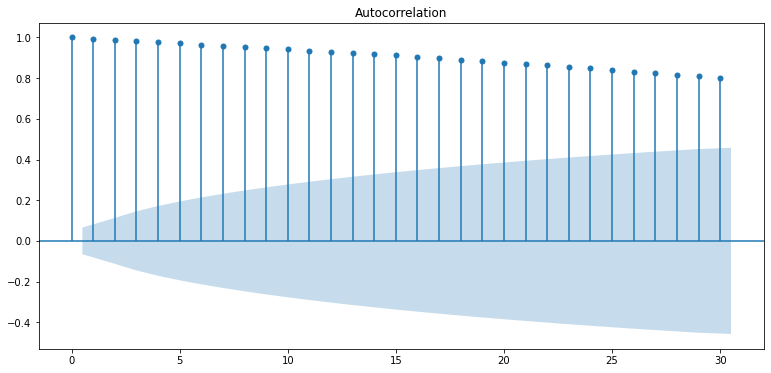

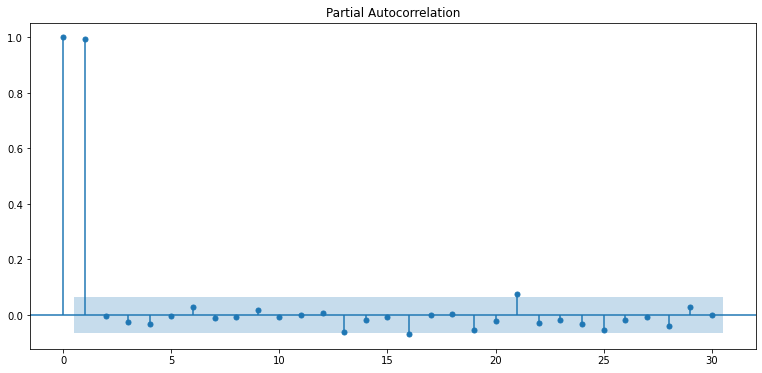

In [66]:
plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.488045e+01
p-value                        1.612377e-27
#Lags Used                     2.000000e+00
Number of Observations Used    8.930000e+02
Critical Value (1%)           -3.437694e+00
Critical Value (5%)           -2.864782e+00
Critical Value (10%)          -2.568496e+00
dtype: float64


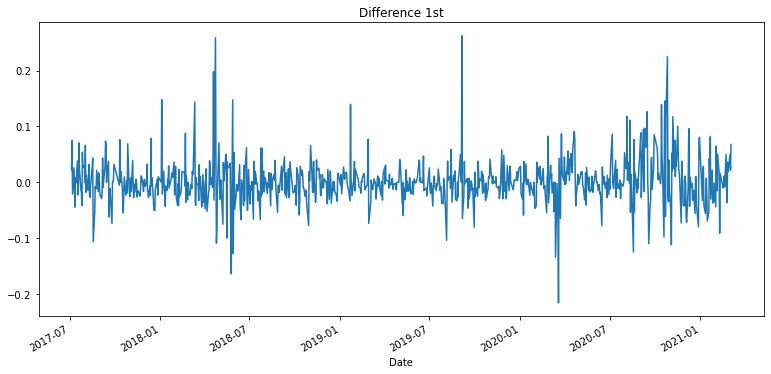

In [67]:
# 1차 차분 구하기
diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.039521e+01
p-value                        1.973428e-18
#Lags Used                     2.100000e+01
Number of Observations Used    8.730000e+02
Critical Value (1%)           -3.437863e+00
Critical Value (5%)           -2.864856e+00
Critical Value (10%)          -2.568536e+00
dtype: float64


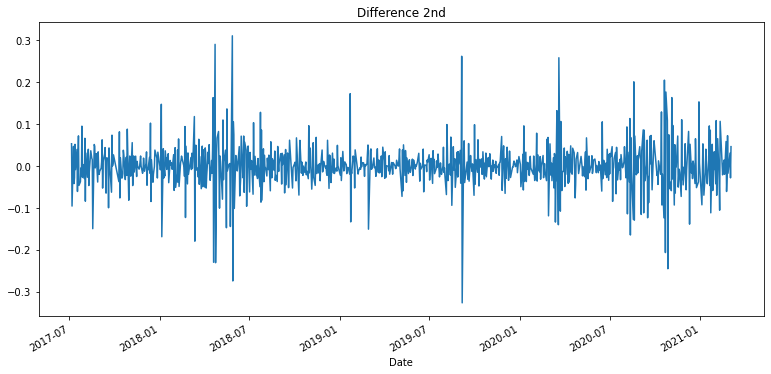

In [68]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

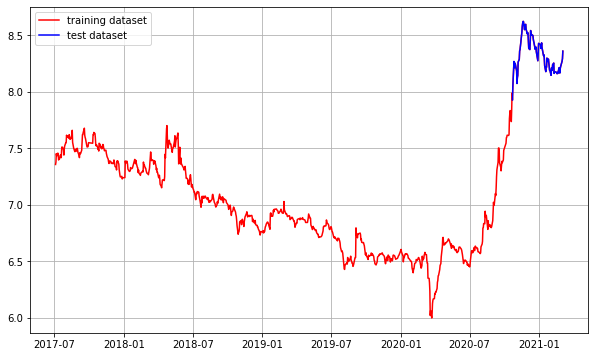

In [69]:
train2_data, test2_data = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test2_data, c='b', label='test dataset')
plt.legend()

In [70]:
print(ts2_log[:2])
print(train2_data.shape)
print(test2_data.shape)

Date
2017-07-04    7.356280
2017-07-05    7.377759
Name: Close, dtype: float64
(807,)
(90,)


In [71]:
model2 = ARIMA(train2_data, order=(1, 1, 0))  
fitted_m2 = model2.fit(disp=-1)  
print(fitted_m2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  806
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1491.764
Method:                       css-mle   S.D. of innovations              0.038
Date:                Thu, 04 Mar 2021   AIC                          -2977.527
Time:                        20:43:08   BIC                          -2963.451
Sample:                             1   HQIC                         -2972.121
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      0.570      0.568      -0.002       0.004
ar.L1.D.Close     0.0381      0.036      1.072      0.284      -0.032       0.108
                                    Root

/home/aiffel-dj29/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj29/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

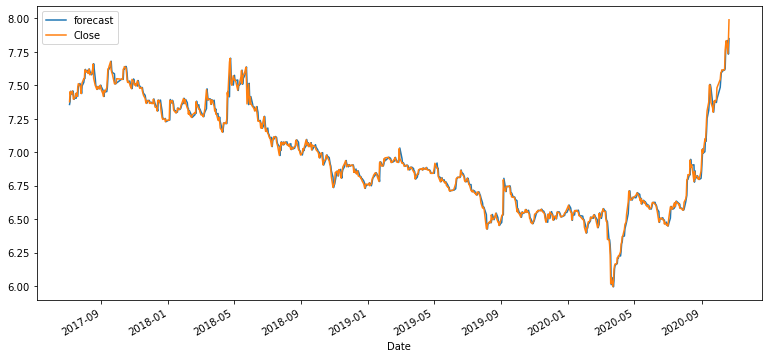

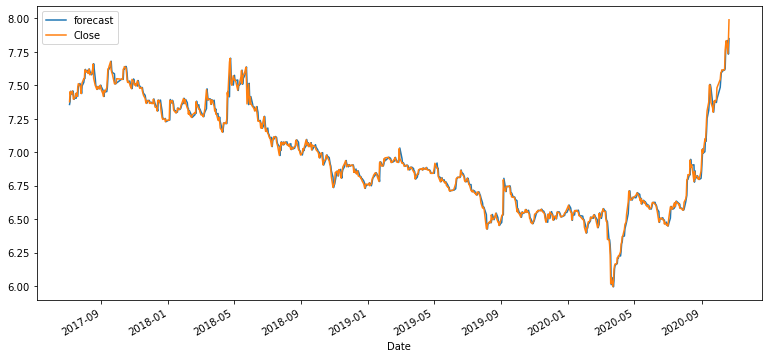

In [72]:
fitted_m2.plot_predict()

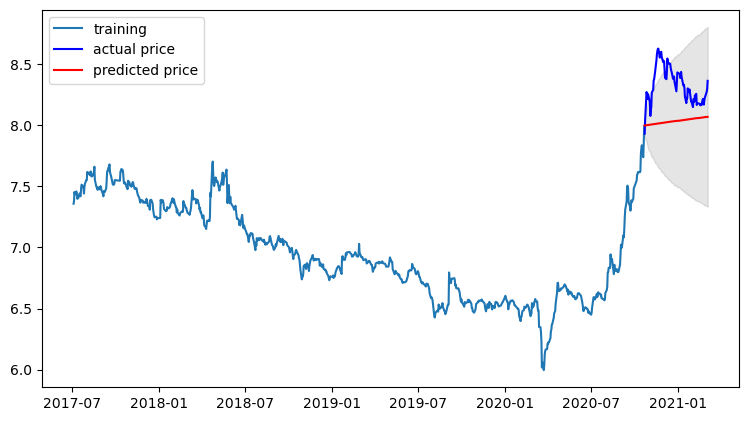

In [74]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m2.forecast(len(test2_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test2_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test2_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test2_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train2_data, label='training')
plt.plot(test2_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [75]:
mse = mean_squared_error(np.exp(test2_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test2_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test2_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test2_data))/np.abs(np.exp(test2_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1678980.6606006976
MAE:  1118.3407361947322
RMSE:  1295.7548613069903
MAPE: 25.00%


### 오차율 너무 크다... 25%.

## 루브릭 평가

1. 시계열의 안정성이 충분히 확인되었는가?
	플로팅과 adfuller 메소드가 모두 적절히 사용되었음
   --> 완료

2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
	p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
    --> 차분 하고 MAPE 오차값 확인함.

3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
	3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨  --> 25% 인데... 어떻하죠?

## 느낀점과 회고

 오랜만에 관심 주제여서 열심히 했습니다. 주식 통계치를 중에 중요한 포인트만 사용한 것 같습니다.